In [1]:
# last edited: 6/13/22
# status: This script is mostly testing different projections for crl and goes data... to no success lol.
#         It seems like the main problems have been isolated at least! try setting proj or geos for projections
#         Just tried changing crl and points to floats, no success in fixing things really

In [2]:
# import stuff
from datetime import datetime
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import numpy as np
import xarray as xr
import shapely.geometry as sgeom
import matplotlib.patches as mpatches
from subprocess import run
import cmocean

os.chdir(  "/Users/etmu9498/research/code/scripts")
import goes_gifs
import make_plots

In [5]:
# defining functions (very similar to those found in goes_gifs.py, but I wanted to mess with things in goes_gif_helper so 
# I made this separate notebook)

def collocation_test( goes_names, goes_data_path, crl_name, crl_path):

    channel_name = "CMI_C10"
    channel_full_name = "GOES-16 Lower Water Vapor Channel"
    os.chdir( goes_data_path)
    first_dataset = xr.open_dataset( goes_names[ 0])
    output_folder = "collocation-test"
    plot_color = 'cividis'
    flight_line_color = 'k'
    goes_gif_helper( flight_line_color, plot_color, output_folder, channel_name, channel_full_name, goes_names, goes_data_path, crl_name, crl_path)


def goes_gif_helper( flight_line_color, plot_color, output_folder, channel_name, channel_full_name, goes_names, goes_path, crl_name, crl_path):

    # check if folder already exists. If not, create folder
    os.chdir( "/Users/etmu9498/research/figures/goes-gifs/")
    if not os.path.isdir( output_folder):
        os.makedirs( output_folder)
        print( 'New folder created')
    else:
        print( 'Existing folder accessed')
    os.chdir(goes_path)

    # make images for gif
    for goes_ind in range( len( goes_names)):
        # load data for this specific goes_ind
        C = xr.open_dataset( goes_names[ goes_ind])
        t_max = np.max( C[ channel_name].data )
        t_min = np.min( C[ channel_name].data )

        # Scan's start time, converted to datetime object
        # Scan's end time, converted to datetime object
        # File creation time, convert to datetime object
        # The 't' variable is the scan's midpoint time
        scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
        file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')
        midpoint = str(C['t'].data)[:-8]
        scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')
        # access wv data!
        wv_upper = C[ channel_name].data
        print("Starting to make image " + str( goes_ind + 1))

       
    
        ## code you can change to mess with projections!
        ## I think I've figured out the projection issue! When plotting the GOES data or flight path with ax.plot or ax.imshow,
        ## the transform option is for specifying the trasform the data CURRENTLY HAS! So GOES should be geostationary and the 
        ## path should be plate carree. Choosing the projection in plt.axes is the only way to change the plot's projection and
        ## automatically correctly plots the two data points! so only change the plt.axes code!!!!

        fig = plt.figure(figsize=(15, 12))
        dat = C.metpy.parse_cf(channel_name)
        x = dat.x
        y = dat.y
        # defining projection for goes data, it's a geostationary projection! Don't change this
        geos = dat.metpy.cartopy_crs
        
        # old wrong code
        # ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree() )
        
        # This is the one projection that can be changed! picking anything here should work just find
        ax = plt.axes(projection= ccrs.Mercator() ) # ccrs.PlateCarree() ) # geos)

        ext = [-65, -45, 10, 25]
        # make sure to choose a transform for the extent as well!
        # actually, don't change the transform, for the same reasons specified above for plotting
        ax.set_extent(ext, ccrs.PlateCarree())
        
        # don't change this!
        proj = ccrs.PlateCarree()
        # ccrs.Mercator()
        # ccrs.PlateCarree()
        # ccrs.Miller()
        # # defining projection for points and line
        # center_lon = C.geospatial_lat_lon_extent.geospatial_lon_center
        # ccrs.Geostationary(central_longitude=center_lon, globe=ccrs.Globe(semimajor_axis=6378137.0,semiminor_axis=6356752.3))
        
        
        
        
        # legend and title
        shape = mpatches.Rectangle((0, 0), 1, 1, facecolor=flight_line_color)
        ax.legend([ shape], ['CRL Flight Path'])
        plt.title( channel_full_name, fontweight='bold', fontsize=15, loc='left')
        plt.title('TC Sam, {}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')),
                  loc='right')
        ax.gridlines(draw_labels=True)

        
        # get crl data
        os.chdir( crl_path)
        crl_data = xr.open_dataset( crl_name)
        os.chdir( goes_path)

        
        # plot goes data
        img = ax.imshow( wv_upper, origin='upper',
                  cmap= plot_color,
                  extent=(x.min(), x.max(), y.min(), y.max()),
                  # don't change this transform!
                  transform=geos, vmin=t_min, vmax=t_max )
        fig.colorbar(mappable=img, label="Brightness Temperature (K)")
        
                
        # plot star showing plane position
        mid_int = ( int( midpoint[11:13]) + int( midpoint[14:16]) / 60 + int(midpoint[17:19] ) / 3600 )
        if mid_int < 10.0:
            mid_int = mid_int + 24.0
        # look at only the decimal places for time ( minutes + seconds)
        for i in range( len( crl_data.time)):
            if ( crl_data.time[i] % 1 <= mid_int % 1 + .01) and ( crl_data.time[i] % 1 >= mid_int % 1 -.01) and (np.rint( crl_data.time[i] ) == np.rint( mid_int)):
                # make star
                long = float( crl_data.Lon[i].values )
                latit = float( crl_data.Lat[i].values )
                # ax.scatter( long, latit, s=200, c= flight_line_color, marker='*', transform=proj ) # marker = 's'
                break

    
        # plot flight path line            
        lon = [float( val) for val in crl_data.Lon.values]
        lat = [float( val) for val in crl_data.Lat.values]
        track = sgeom.LineString(zip(lon, lat))
        
        # ax.add_geometries([track], crs=proj,facecolor='none', edgecolor= 'g', linewidth=1)
        
        print( np.max( lon))
        print( np.min( lon))
        ax.plot( lon, lat,c = flight_line_color, transform= proj )
        
        
        # save figure
        os.chdir( "/Users/etmu9498/research/figures/goes-gifs/" + output_folder)
        plt.savefig( "goes-image-" + str( goes_ind) + ".png") # str( file_names[ goes_ind][0: -3] ) + '.png', bbox_inches=0)
        os.chdir( goes_path)
        print( "Image " + str( goes_ind + 1) + " complete" )


crl data files:
0) P3_20210811H1_200000-224759.cdf
1) P3_20210812H1_095513-125927.cdf
2) P3_20210812H2_212248-235510.cdf
3) P3_20210813H1_091801-113558.cdf
4) P3_20210816H1_085245-123459.cdf
5) P3_20210816H1_090000-102359.cdf
6) P3_20210817H1_094204-132058.cdf
7) P3_20210818H1_211425-244159.cdf
8) P3_20210819H1_213003-244159.cdf
9) P3_20210820H1_212402-245958.cdf
10) P3_20210821H2_213903-225658.cdf
11) P3_20210821H2_213903-262058.cdf
12) P3_20210827H1_203112-275220.cdf
13) P3_20210828H1_200115-221321.cdf
14) P3_20210829H1_171201-223719.cdf
15) P3_20210925H1_211201-243558.cdf
16) P3_20210926H1_220900-255058.cdf
17) P3_20210927H1_213003-253558.cdf
18) P3_20210929H2_211201-261159.cdf
GOES satellite data files:
0) OR_ABI-L2-MCMIPM1-M6_G16_s20212692238252_e20212692238314_c20212692238398.nc
Existing folder accessed
Starting to make image 1
-48.8385009765625
-52.79249954223633
Image 1 complete


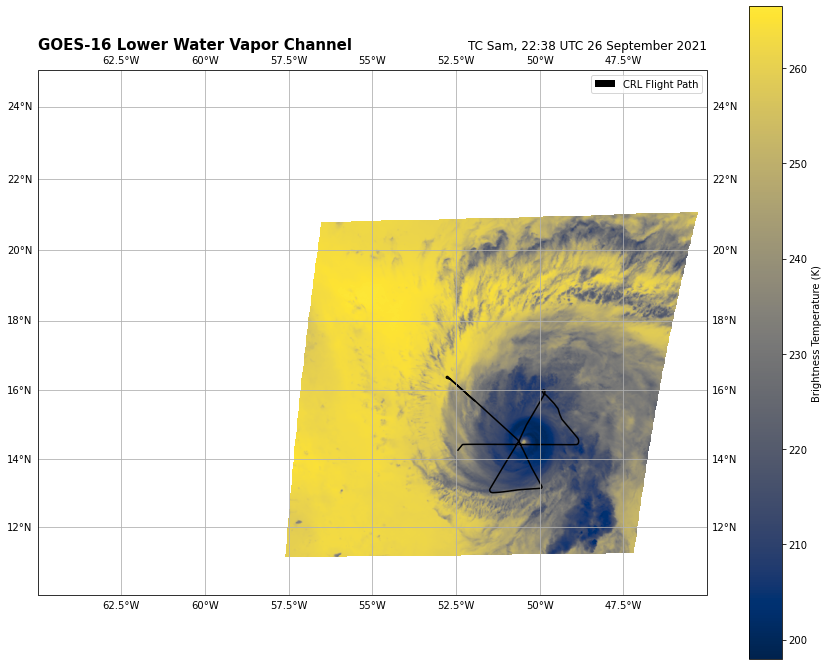

In [6]:
crl_path = "/Users/etmu9498/research/data/CRL_data/2021"
crl_list = make_plots.load_crl( crl_path)
crl_name = crl_list[ 16]
collocation_path = "/Users/etmu9498/research/data/goes-satellite/collocation-test"
collocation_names = goes_gifs.load_goes( collocation_path)

collocation_test( collocation_names, collocation_path, crl_name, crl_path)